# <b style='color:orange'> Classifying with MMoCHi

**Author:** Daniel Caron

#### In this notebook, we walk through the general usage of the MMoCHi classifier to annotate celltypes in CITE-Seq data, integrated across multiple datasets and predict on a held out dataset.
***
### MMoCHi is a useful tool for:
    1. Identifying predefined cell types or states 
    2. Labelling cells by lineage when other sources of variation (such as activation state) dominate the variation in the dataset
    3. Distinguishing cell types that don't form discrete clusters in unsupervised analyses
    4. Integrating cell identification across samples — even when UMAP integration fails

## <b style='color:orange'> Import packages

In [1]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import mmochi as mmc
import adtnormpy

## <b style='color:orange'> Downloading and preprocessing the data 
Often, multiple samples, batches, or datasets may need to be annotated by a unified system. Here, we will demonstrate MMoCHi being used across multiple 10X Genomics sequencing runs (pbmc_10k_protein_v3 and 5k_pbmc_protein_v3) and being used to predict annotations on a held out dataset (pbmc_1k_protein_v3). First, we need to download the example datasets, perform normalization, and format them with the GEX data in the .X and the ADT data in the .obsm['protein_counts'].

In [2]:
files = ['pbmc_10k_protein_v3.h5','5k_pbmc_protein_v3.h5','pbmc_1k_protein_v3.h5']
cellranger_versions = ['3.0.0','3.0.2','3.0.0']
base_url =  f"http://cf.10xgenomics.com/samples/cell-exp/"
urls = [base_url + f"{v}/{i}/{i}_filtered_feature_bc_matrix.h5" for i,v in zip(files,cellranger_versions)]
adatas = mmc.utils.preprocess_adatas(files.copy(),backup_urls = urls,log_CP_ADT=10,log_CP_GEX=100000)
held_out_batch, held_out_file = adatas.pop(2),files.pop(2)
adata = anndata.concat(adatas,merge='first',keys=files,label='batch',index_unique='_')

 /home/ubuntu/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<div class="alert alert-block alert-info">
<b>Training tip — data selection:</b> Carefully select which biological conditions, sequencing chemistries, alignment, and preprocessing before training your classifier to be representative of your total data!
</div>

We'll quickly run through scanpy's pipeline to create a UMAP for this dataset and calculate leiden clusters for reference later!

2022-08-06 13:04:07.402055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-06 13:04:07.402080: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


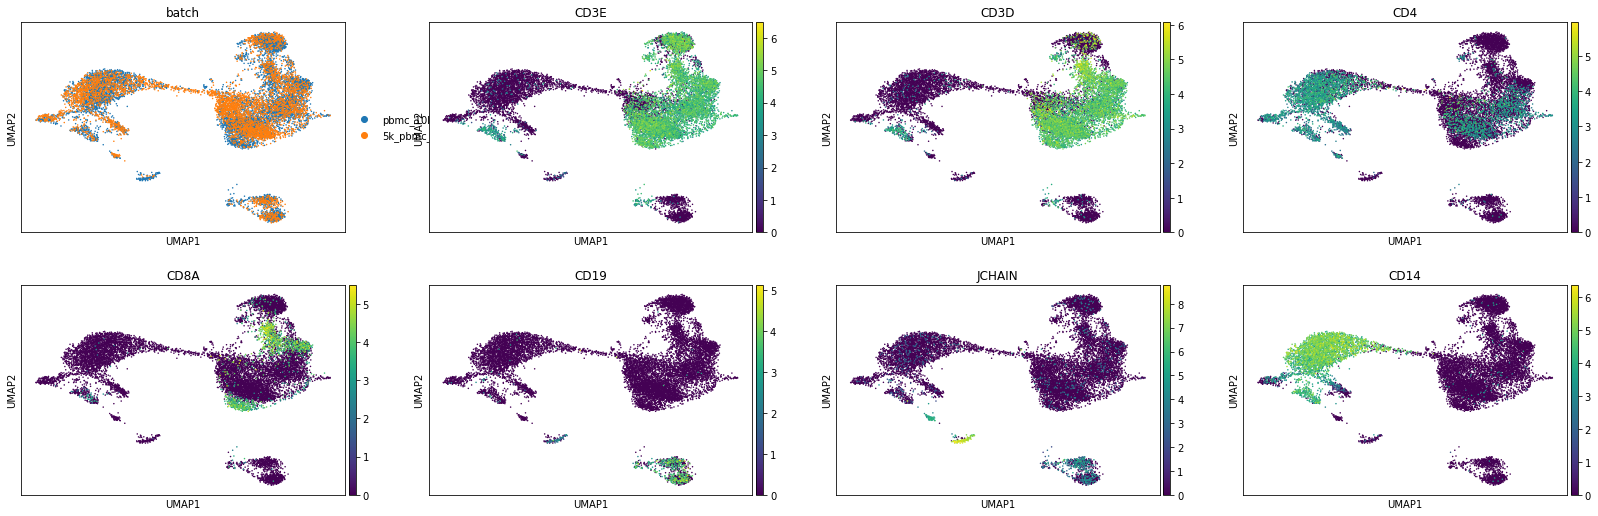

In [3]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.external.pp.harmony_integrate(adata,adjusted_basis='X_pca',key='batch',verbose=False,max_iter_harmony=20)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata,color=['batch','CD3E','CD3D','CD4','CD8A','CD19','JCHAIN','CD14'])

## <b style='color:orange'> Normalizing ADTs - Landmark Registration
Because of variation in antibody staining conditions, CITE-Seq data requires careful integration! To integrate CITE-Seq data across datasets, we have deveoped a landmark registration function, which calculates a density function of marker expression, and then aligns the peaks across each batch.

<div class="alert alert-block alert-warning">
<b>Check carefully!</b> First, transform your data using arcsine or log normalization. Tune the transformation until you have separation of positive and negative populations on bimodal or trimodal markers. Then, select a CITE-Seq landmark registration package. Here, we have two options: ADTnorm and mmc.landmark_register_adts()
</div>

ADTnorm takes in raw protein counts and handles both the arcsine transformation, and landmark registration to align the positive and negative peaks. To make this landmark registration reproducible for future data, here we fix the peak alignment for all markers to 1 (for negative peaks) or 3 (for positive peaks). 

In [4]:
adata = adtnormpy.adt_norm(adata,sample_column='batch',batch_column='batch',ADT_location='protein_counts',save_outpath=None,save_intermediate=False,
                        input_raw_counts=True,exclude_zeroes=True,target_landmark=(1,3))

[1] "Will align negative peak to 1 and right-most positive peak to 3"
[1] "ADTnorm will process all the ADT markers from the ADT matrix:CD8a, CD15, IgG2b_control, CD16, CD56, CD4, CD25, CD14, PD-1, CD127, IgG2a_control, CD3, TIGIT, CD19, IgG1_control, CD45RO, CD45RA"
[1] "CD8a"
[1] "Zeroes excluded..."
                           [,1]     [,2]
pbmc_10k_protein_v3.h5 2.392486 7.682272
5k_pbmc_protein_v3.h5  1.496157 5.132490
                           [,1]     [,2]     [,3]
pbmc_10k_protein_v3.h5 2.392486 5.037871 7.682272
5k_pbmc_protein_v3.h5  1.496157 3.560180 5.132490
Progress:  Each dot is a curve
..
[1] "CD15"
[1] "Zeroes excluded..."
                           [,1]     [,2]
pbmc_10k_protein_v3.h5 3.781003 7.460712
5k_pbmc_protein_v3.h5  1.774254       NA
                           [,1]     [,2]     [,3]
pbmc_10k_protein_v3.h5 3.781003 7.116986 7.460712
5k_pbmc_protein_v3.h5  1.774254 2.619831 2.963557
Progress:  Each dot is a curve
..
[1] "IgG2b_control"
[1] "Zeroes excluded..."
 

## <b style='color:orange'>Define the hierarchy

The Hierarchy class supports setting up the classification scheme and storing the classifiers. Here, we define a Hierarchy, with default settings for the training conditions. Then, we add classification levels to it. These classification levels will eventually become Random Forest classifiers. Subsets are assigned below each classification subset, and defining markers for each subset are specified.

In [5]:
h= mmc.Hierarchy(default_min_events=15,default_class_weight = 'balanced')

To add a classification level, you define a name, parent node (the root node in a Hierarchy object is "All"), and markers. Negative and positive markers for each population can be defined, as well as more complex boolean gating rules. Here, we add a gross immune compoenent, to segregate lymphoid and myeloid cells.

In [6]:
h.add_classification('Gross','All', ['CD14','CD33','MARCO','MERTK','CD3','CD19','CD127','JCHAIN']) 
h.add_subset('Lymphocyte','Gross',dict(neg = ['CD14','CD33','MARCO','MERTK'],any_of=['CD3','CD19','CD127','JCHAIN'],n=1))
h.add_subset('Myelocyte','Gross',dict(any_of = ['CD14','CD33','MARCO','MERTK'],n=1, neg=['CD3','CD19','CD127','JCHAIN']))

 /home/ubuntu/MMoCHi/mmochi/hierarchy.py:162: FutureWarning:Possible nested set at position 5


Distinguishing these populations in a hierarchy helps prevent the algorithm from confusing cell types that are only very distantly related.

In [7]:
h.add_classification('Lymphoid','Lymphocyte',['CD3','CD19','CD56','CD127','JCHAIN'])           
h.add_subset('T cell','Lymphoid',dict(pos=['CD3','CD127'],neg=['CD19','JCHAIN']))
h.add_subset('B cell','Lymphoid',dict(any_of=['CD19'], neg=['CD3','CD127','JCHAIN']))
h.add_subset('Plasma cell','Lymphoid',dict(any_of=['JCHAIN'], neg=['CD3','CD127']))
h.add_subset('NK/ILC','Lymphoid',dict(neg=['CD19','JCHAIN','CD3'], any_of=['CD127','CD56']))

<div class="alert alert-block alert-info">
<b>Training tip — hierarchy design:</b> Here, the hierarchy is setup to reflect known shared precursors and cell lineages, but lineage-based hierarchies aren't always the most effective! When adding new cells to the hierarchy, consider what other cell types share the most transcriptomic and phenotypic identity. If two or more cell types share more features across an axis than they differ, it may be helpful to group them together and separate them lower in the hierarchy!
</div>

In [8]:
h.add_classification('NK/ILC Subsets','NK/ILC',['CD127','EOMES'])# NCR3
h.add_subset('NK','NK/ILC Subsets',['neg','pos']) 
h.add_subset('ILC','NK/ILC Subsets',['pos','neg'])

Each subset's marker expression can be defined either by lists of "pos", "neg", or "any", where markers are ordered the same as the classification level above it, or as a dictionary, which is interpreted by the `mmc.hierarchy.gt_defs` function, allowing for complex gating strategies. See the docstring for more details on possible options.

In [9]:
h.add_classification('CD4_CD8','T cell',['CD4','CD8a','CD4_gex','CD8A'],clf_kwargs=dict(max_features=.25))
h.add_subset('CD4 T cell','CD4_CD8',['pos','neg','any','neg'])
h.add_subset('CD8 T cell','CD4_CD8',['neg','pos','neg','pos'])

<div class="alert alert-block alert-warning">
<b>Training tip — clf_kwargs:</b> To optimize cell classification, sometimes the default random forest needs adjustment. For example, here CD4 and CD8 T cells are reliably distinguishable by only a few markers. The hierarchy supports this by allowing each classification level to pass their own kwargs to the sklearn RandomForestClassifier. Here, we increase max_features to decrease the randomness of the forest. Read more about kwarg options <b><u><a here="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">here</a></b></u>!
</div>

Now that the hierachy has been defined, we can take a look at it! These helper functions are great for visualizing the classification levels (ovals) and subset defintiions (rectangles).

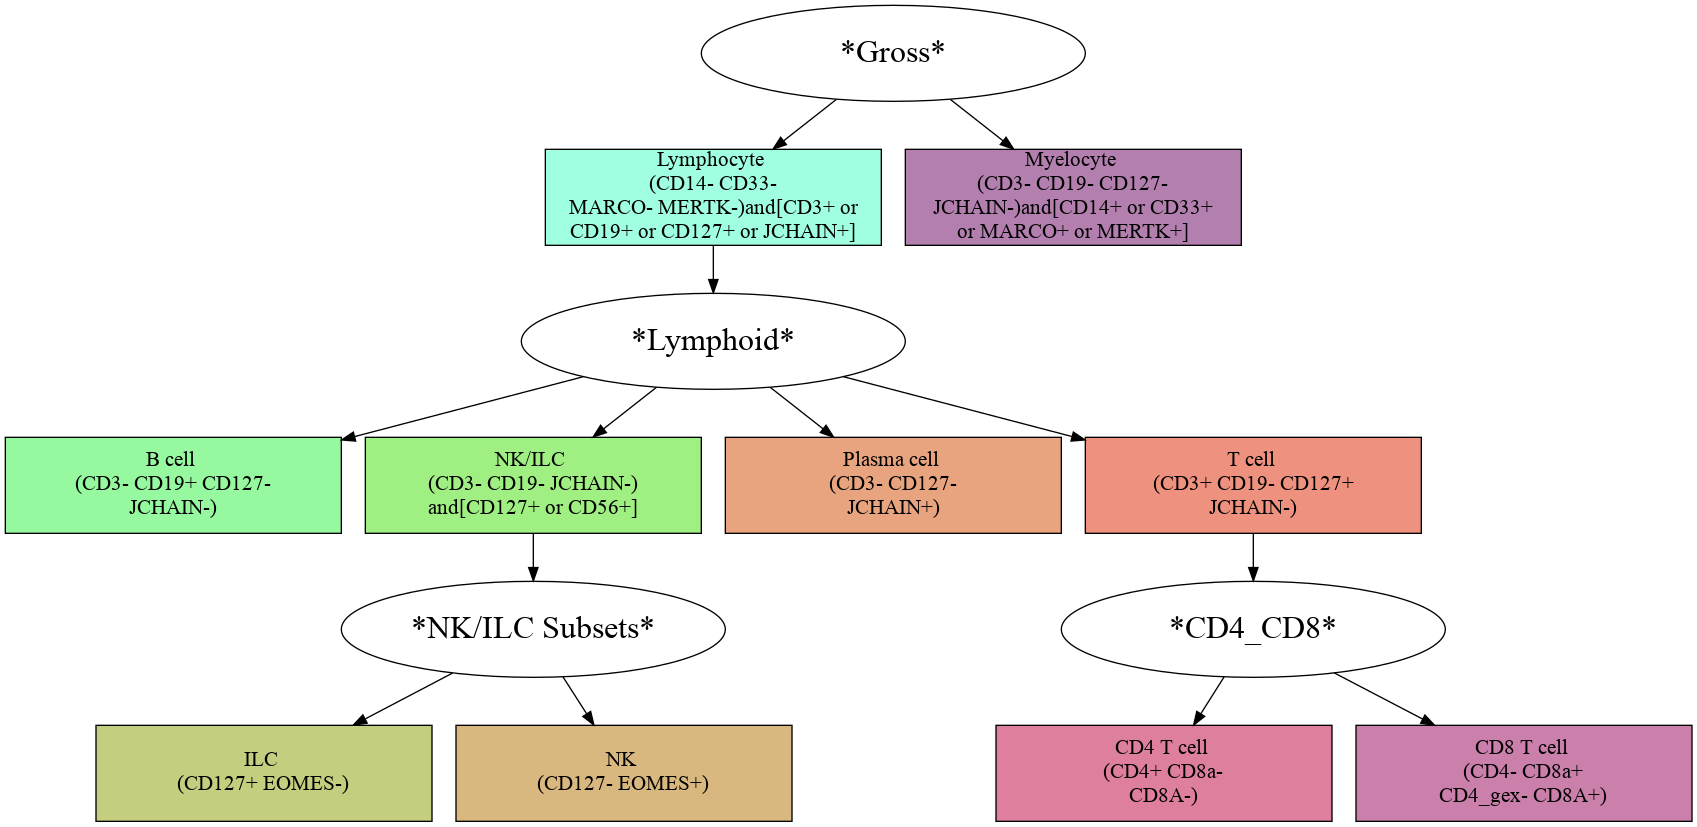

In [10]:
h.color_dict(True,rot=1,hue=3, mode='DEPTH')
h.display(True)

## <b style='color:orange'> Run thresholding
In order to define ground-truth data for training the classifier, we must identify positive and negative populations for each marker defined in the hierarchy. The Hierarchy object stores thresholds for each marker, which can be saved and loaded from a .csv for convenience.    

In [11]:
h.reset_thresholds()
h.load_thresholds('data/integrated_thresholds.csv')

Loaded thresholds.


Thresholding can be performed on any transformation of the ADTs that produces clear positive and negative populations. Although MMoCHi will attempt to predict thresholds from a gaussian mixed model, these predictions are far from perfect. Thresholds must be carefully defined for each marker used in the hierarchy for each sample. Using the "fancy" keyword in any mode name activates iPython widgets!

Running with batch batch


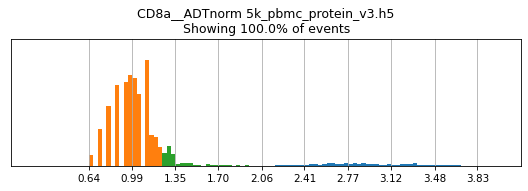

FloatSlider(value=1.9197429148604896, layout=Layout(width='600px'), max=4.18986157208037)

FloatSlider(value=1.2368111282606025, layout=Layout(width='600px'), max=4.18986157208037)

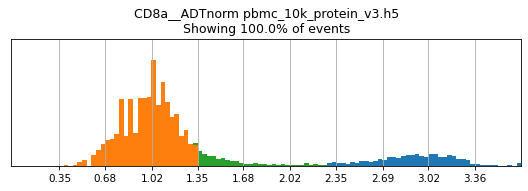

FloatSlider(value=2.2948017679950787, layout=Layout(width='600px'), max=3.692401740883328)

FloatSlider(value=1.3475699650651072, layout=Layout(width='600px'), max=3.692401740883328)

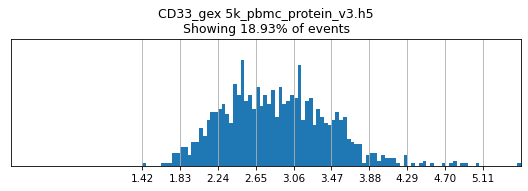

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.524623394012451)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.524623394012451)

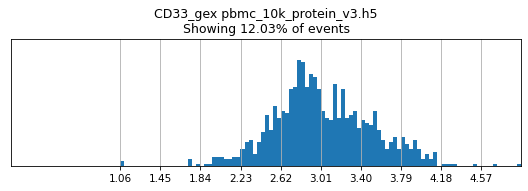

FloatSlider(value=0.5, layout=Layout(width='600px'), max=4.956134796142578)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=4.956134796142578)

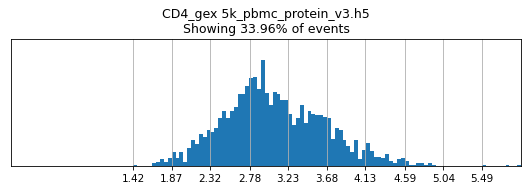

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.945295810699463)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.945295810699463)

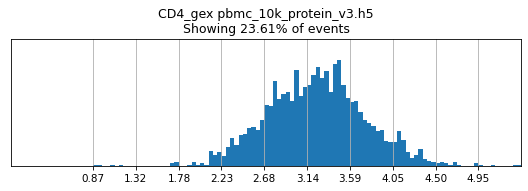

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.407062530517578)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.407062530517578)

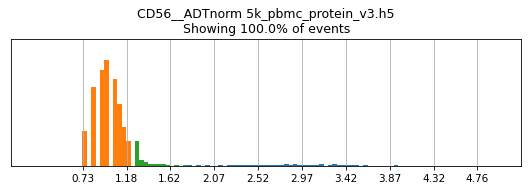

FloatSlider(value=1.8, layout=Layout(width='600px'), max=5.213125395005375)

FloatSlider(value=1.2247626377169587, layout=Layout(width='600px'), max=5.213125395005375)

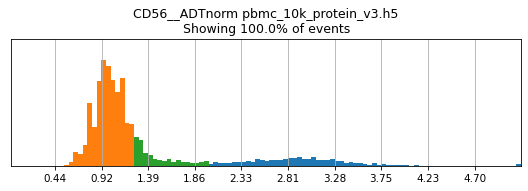

FloatSlider(value=2.0, layout=Layout(width='600px'), max=5.172754107352206)

FloatSlider(value=1.250587343497175, layout=Layout(width='600px'), max=5.172754107352206)

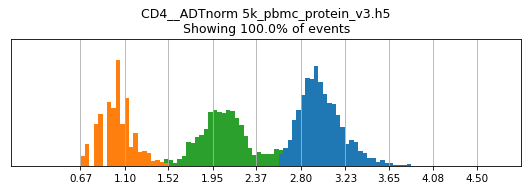

FloatSlider(value=2.6, layout=Layout(width='600px'), max=4.929352252079634)

FloatSlider(value=1.5, layout=Layout(width='600px'), max=4.929352252079634)

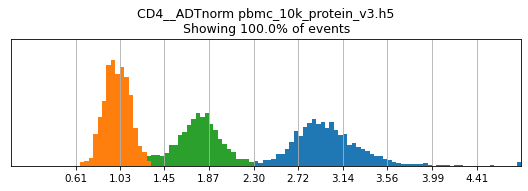

FloatSlider(value=2.3, layout=Layout(width='600px'), max=4.830388209454579)

FloatSlider(value=1.3, layout=Layout(width='600px'), max=4.830388209454579)

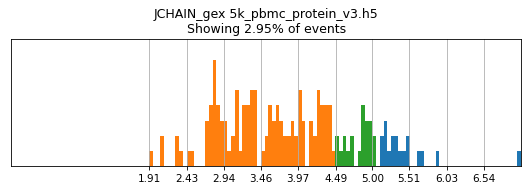

FloatSlider(value=5.1, layout=Layout(width='600px'), max=7.057889938354492)

FloatSlider(value=4.5, layout=Layout(width='600px'), max=7.057889938354492)

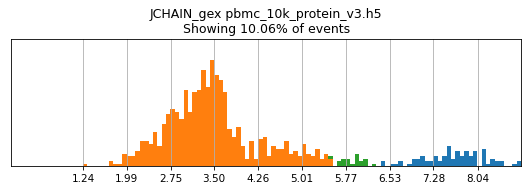

FloatSlider(value=6.3, layout=Layout(width='600px'), max=8.791997909545898)

FloatSlider(value=5.5, layout=Layout(width='600px'), max=8.791997909545898)

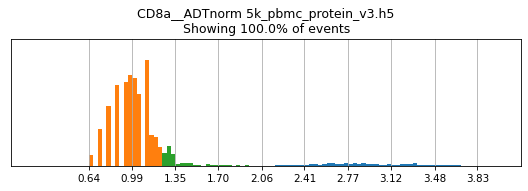

FloatSlider(value=1.9197429148604896, layout=Layout(width='600px'), max=4.18986157208037)

FloatSlider(value=1.2368111282606025, layout=Layout(width='600px'), max=4.18986157208037)

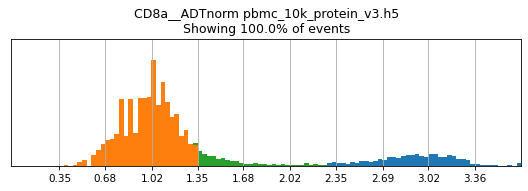

FloatSlider(value=2.2948017679950787, layout=Layout(width='600px'), max=3.692401740883328)

FloatSlider(value=1.3475699650651072, layout=Layout(width='600px'), max=3.692401740883328)

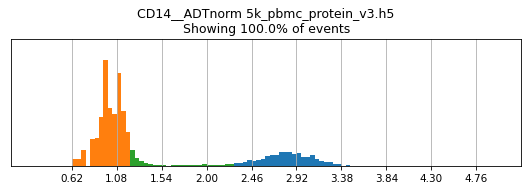

FloatSlider(value=2.2497279454927246, layout=Layout(width='600px'), max=5.219108902800934)

FloatSlider(value=1.2300154169541038, layout=Layout(width='600px'), max=5.219108902800934)

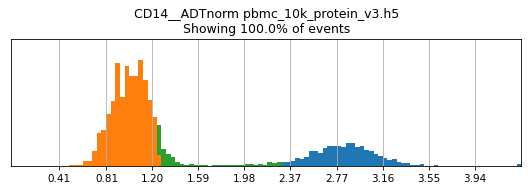

FloatSlider(value=2.303778861633019, layout=Layout(width='600px'), max=4.333737736529085)

FloatSlider(value=1.2498015948441616, layout=Layout(width='600px'), max=4.333737736529085)

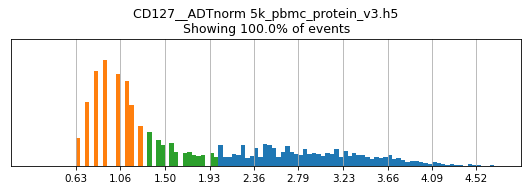

FloatSlider(value=2.0, layout=Layout(width='600px'), max=4.956775414173064)

FloatSlider(value=1.3404411444490647, layout=Layout(width='600px'), max=4.956775414173064)

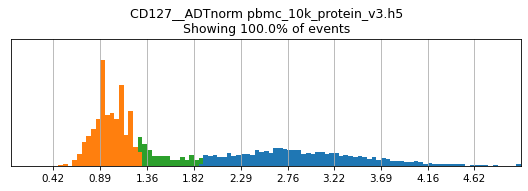

FloatSlider(value=1.9, layout=Layout(width='600px'), max=5.089575322984334)

FloatSlider(value=1.2828998691679068, layout=Layout(width='600px'), max=5.089575322984334)

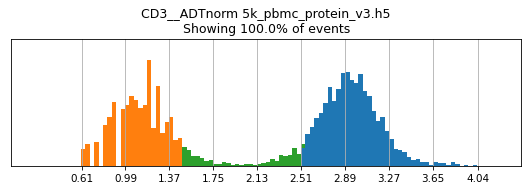

FloatSlider(value=2.519185326696624, layout=Layout(width='600px'), max=4.417226978773744)

FloatSlider(value=1.49161414191736, layout=Layout(width='600px'), max=4.417226978773744)

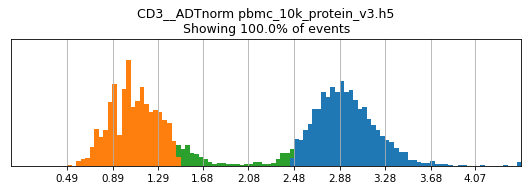

FloatSlider(value=2.464044974567813, layout=Layout(width='600px'), max=4.471909022218024)

FloatSlider(value=1.4638821171319207, layout=Layout(width='600px'), max=4.471909022218024)

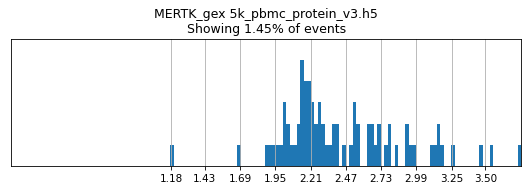

FloatSlider(value=1.1, layout=Layout(width='600px'), max=3.7636451721191406)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.7636451721191406)

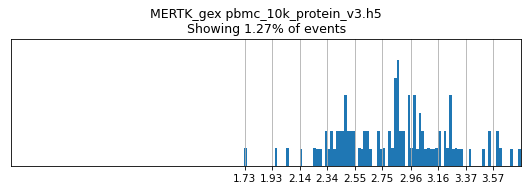

FloatSlider(value=0.5, layout=Layout(width='600px'), max=3.779682159423828)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.779682159423828)

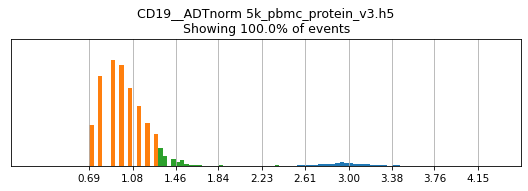

FloatSlider(value=2.383089410769552, layout=Layout(width='600px'), max=4.530379356714889)

FloatSlider(value=1.3136477262829038, layout=Layout(width='600px'), max=4.530379356714889)

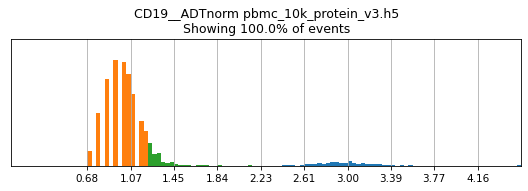

FloatSlider(value=2.2, layout=Layout(width='600px'), max=4.548130180102314)

FloatSlider(value=1.2312463387428731, layout=Layout(width='600px'), max=4.548130180102314)

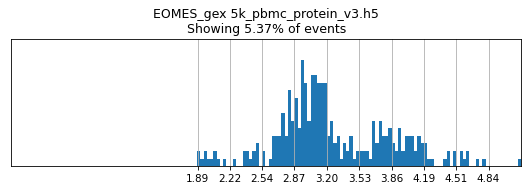

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.170649528503418)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.170649528503418)

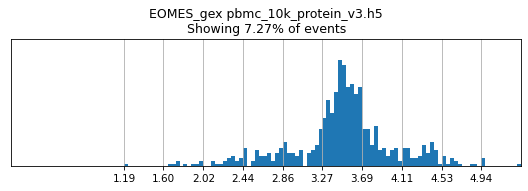

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.360655307769775)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.360655307769775)

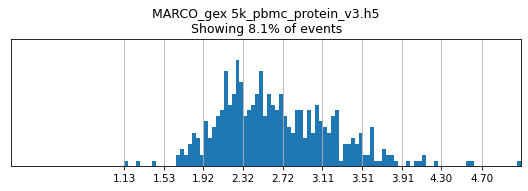

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.095819473266602)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.095819473266602)

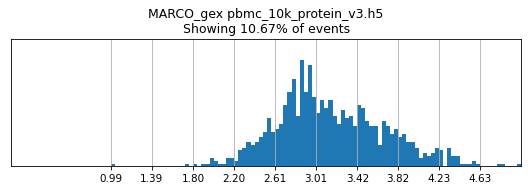

FloatSlider(value=0.5, layout=Layout(width='600px'), max=5.038687229156494)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=5.038687229156494)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [12]:
h.run_all_thresholds(adata,data_key='ADTnorm',batch_key='batch',plot_all=False,mode='fancy rerun all')

<div class="alert alert-block alert-info">
    <b>How do I choose the best thresholds?</b> Carefully gating your populations can greatly improve the training data your classifier recieves, and therefore your cell calls, but figuring out how gates need to be adjusted can be tricky! On cleanly bimodal markers, you want to include cells that are clearly in the positive and negative distributions, leaving events with middling expression of the marker undefined. Be careful not to leave too many cells undefined though! Limiting your calls to only the most extreme positive and negative cells may inadvertently train the classifier on only a subset of the cell lineage, or on only the highest quality of data, neither of which would produce effective calls! MMoCHi has other tools to assist with threshold selection for more complex markers, which are either not bimodal or on cell subsets that are defined by combinatorial expression. Tutorials in progress will cover this in more detail!
</div>

Be sure to save your thresholds to a .csv, as these will be useful as you iteratively train the classifier to fine tune population identification! When overwriting a file, this special save function saves non-destructively, replacing only the markers that you define each run — so if you remove a marker temporarily from the hierarchy, those carefully defined thresholds will not be lost!

In [13]:
h.save_thresholds('data/integrated_thresholds.csv')

Saving non-destructively...


## <b style='color:orange'> Train and run the classifier
It's finally time to train the classifier. The classify function works its way down the hiarachy, identifying ground truth populations, training a RandomForestClassifier, and storing that classifier back in the hierarchy. Then, it uses that classifier to predict cell subsets at that level, before moving down to classifiers for those subsets. Future runs of the classify function with `retrain=False` will be able to use those classifier objects to predict celltypes without retraining.

In [14]:
adata,hierarchy = mmc.classify(adata, h.copy(), 'lin', 'ADTnorm', batch_key='batch',
                               retrain = True,n_estimators=100,clf_kwargs = dict(max_depth=20),in_danger_noise_checker=True)

Setting up...
Using .X and ADTnorm
Reducing features...


Running with batch batch
Running ground truths in 5k_pbmc_protein_v3.h5


Set up complete.
Using 14740 features
Data subsetted on All in All
Running ground truths for Gross...


Running ground truths in pbmc_10k_protein_v3.h5
Checking subsets for minimum events...
Manually made a balanced class_weight: {'Lymphocyte': 1.1551398993637658, 'Myelocyte': 1.9977222128552057}
{'max_depth': 20, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Training using 5k_pbmc_protein_v3.h5...
3164 real cells in training set...


Preparing training data for Gross...
Initializing classifier for Gross...
Choosing training data...
Resampling...
Found: 1 noise and 4 in danger of 3164 events.
col_0  Lymphocyte  Myelocyte
row_0                       
0.0          2415        744
1.0             2          2
2.0             0          1
Training with 4854 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
Training using pbmc_10k_protein_v3.h5...
4568 real cells in training set...


Choosing training data...
Resampling...
Found: 7 noise and 108 in danger of 4568 events.
col_0  Lymphocyte  Myelocyte
row_0                       
0.0          3260       1193
1.0           108          0
2.0             2          5
Training with 7816 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


Merging data into adata.obsm['lin']
Predicting for Gross...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.9s finished


Merging data into adata.obsm['lin']
Predicted:
Lymphocyte    9365
Myelocyte     3746
Name: Gross_class, dtype: int64


Running ground truths in 5k_pbmc_protein_v3.h5


Data subsetted on Lymphocyte in Gross
Running ground truths for Lymphoid...


Running ground truths in pbmc_10k_protein_v3.h5
Checking subsets for minimum events...
Manually made a balanced class_weight: {'B cell': 2.961077217899991, 'NK/ILC': 2.4117175701486726, 'Plasma cell': 9.101986258292959, 'T cell': 1.1935674151899316}
{'max_depth': 20, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Training using 5k_pbmc_protein_v3.h5...
2025 real cells in training set...


Preparing training data for Lymphoid...
Initializing classifier for Lymphoid...
Choosing training data...
Resampling...
Found: 13 noise and 11 in danger of 2025 events.
col_0  B cell  NK/ILC  Plasma cell  T cell
row_0                                     
0.0       211     238           10    1542
1.0         1       5            0       5
2.0         2       8            1       2
Training with 6288 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
Training using pbmc_10k_protein_v3.h5...
3201 real cells in training set...


Choosing training data...
Resampling...
Found: 13 noise and 8 in danger of 3201 events.
col_0  B cell  NK/ILC  Plasma cell  T cell
row_0                                     
0.0       371     629           49    2131
1.0         0       4            1       3
2.0         3       8            1       1
Training with 8596 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Merging data into adata.obsm['lin']
Predicting for Lymphoid...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.6s finished
Running ground truths in 5k_pbmc_protein_v3.h5


Merging data into adata.obsm['lin']
Predicted:
T cell         6974
NK/ILC         1354
B cell          914
Plasma cell     123
Name: Lymphoid_class, dtype: int64
Data subsetted on NK/ILC in Lymphoid
Running ground truths for NK/ILC Subsets...


Running ground truths in pbmc_10k_protein_v3.h5
Checking subsets for minimum events...
Spiking in 8 of ILC in 5k_pbmc_protein_v3.h5 to reach 15 events
Manually made a balanced class_weight: {'ILC': 3.4953385106950408, 'NK': 1.0436221954432099}
{'max_depth': 20, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Training using 5k_pbmc_protein_v3.h5...
82 real cells in training set...


Preparing training data for NK/ILC Subsets...
Initializing classifier for NK/ILC Subsets...
Choosing training data...
Resampling...
Found: 5 noise and 0 in danger of 82 events.
col_0  ILC  NK
row_0         
0.0      2  75
2.0      5   0
No "in danger" found
Training with 150 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
Training using pbmc_10k_protein_v3.h5...
145 real cells in training set...


Choosing training data...
Resampling...
Found: 7 noise and 4 in danger of 145 events.
col_0  ILC   NK
row_0          
0.0      2  132
1.0      4    0
2.0      7    0
Training with 264 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Merging data into adata.obsm['lin']
Predicting for NK/ILC Subsets...
Merging data into adata.obsm['lin']
Predicted:
NK     1347
ILC       7
Name: NK/ILC Subsets_class, dtype: int64


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
Running ground truths in 5k_pbmc_protein_v3.h5


Data subsetted on T cell in Lymphoid
Running ground truths for CD4_CD8...


Running ground truths in pbmc_10k_protein_v3.h5
Checking subsets for minimum events...
Manually made a balanced class_weight: {'CD4 T cell': 1.1609591237233643, 'CD8 T cell': 1.9685019685029528}
{'max_features': 0.25, 'max_depth': 20, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Training using 5k_pbmc_protein_v3.h5...
2047 real cells in training set...


Preparing training data for CD4_CD8...
Initializing classifier for CD4_CD8...
Choosing training data...
Resampling...
Found: 87 noise and 80 in danger of 2047 events.
col_0  CD4 T cell  CD8 T cell
row_0                        
0.0          1670         210
1.0            13          67
2.0             6          81
Training with 3496 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
Training using pbmc_10k_protein_v3.h5...
2776 real cells in training set...


Choosing training data...
Resampling...
Found: 29 noise and 54 in danger of 2776 events.
col_0  CD4 T cell  CD8 T cell
row_0                        
0.0          1846         847
1.0            20          34
2.0             9          20
Training with 3932 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


Merging data into adata.obsm['lin']
Predicting for CD4_CD8...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.4s finished


Merging data into adata.obsm['lin']
Predicted:
CD4 T cell    5294
CD8 T cell    1680
Name: CD4_CD8_class, dtype: int64


Classification information for each cell is stored by default in a dataframe in the `.obsm['lin']`. This includes information for each classification level on whether a cell was identified by the ground truth thresholding, whether it was set aside as training data, how many times it was represented in the training data (oversampling and the in_danger_noise checker cause cells can both pull training cells randomly with replacement to generate balanced training datasets), its probability identification, and its ultimate classification.

In [15]:
adata.obsm['lin']

,All_class,Gross_gt,Gross_trains,Gross_tcounts,Gross_train,Gross_proba,Gross_class,Lymphoid_gt,Lymphoid_trains,Lymphoid_tcounts,...,NK/ILC Subsets_tcounts,NK/ILC Subsets_train,NK/ILC Subsets_proba,NK/ILC Subsets_class,CD4_CD8_gt,CD4_CD8_trains,CD4_CD8_tcounts,CD4_CD8_train,CD4_CD8_proba,CD4_CD8_class
AAACCCAAGATTGTGA-1_pbmc_10k_protein_v3.h5,All,Myelocyte,False,0.0,False,1.000,Myelocyte,NaN,True,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN
AAACCCACATCGGTTA-1_pbmc_10k_protein_v3.h5,All,Myelocyte,True,4.0,True,0.980,Myelocyte,NaN,True,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN
AAACCCAGTACCGCGT-1_pbmc_10k_protein_v3.h5,All,Myelocyte,True,2.0,True,0.985,Myelocyte,NaN,True,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN
AAACCCAGTATCGAAA-1_pbmc_10k_protein_v3.h5,All,?,False,0.0,False,0.940,Lymphocyte,NK/ILC,True,3.0,...,0.0,False,0.920,NK,NaN,True,NaN,True,NaN,NaN
AAACCCAGTCGTCATA-1_pbmc_10k_protein_v3.h5,All,?,False,0.0,False,0.920,Lymphocyte,NK/ILC,True,1.0,...,1.0,True,0.945,NK,NaN,True,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCACAAG-1_5k_pbmc_protein_v3.h5,All,Lymphocyte,True,0.0,False,0.985,Lymphocyte,?,False,0.0,...,NaN,True,NaN,NaN,CD8 T cell,True,0.0,False,0.897503,CD8 T cell
TTTGTTGCAGTCTTCC-1_5k_pbmc_protein_v3.h5,All,Lymphocyte,True,0.0,False,1.000,Lymphocyte,T cell,True,0.0,...,NaN,True,NaN,NaN,CD4 T cell,True,0.0,False,0.833130,CD4 T cell
TTTGTTGCATGGCCCA-1_5k_pbmc_protein_v3.h5,All,?,False,0.0,False,0.960,Lymphocyte,?,False,0.0,...,NaN,True,NaN,NaN,CD8 T cell,True,0.0,False,0.752817,CD8 T cell
TTTGTTGCATTGCCGG-1_5k_pbmc_protein_v3.h5,All,Myelocyte,False,0.0,False,0.985,Myelocyte,NaN,True,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN


Immediately after classification, you may be interested in identifying cells by their lowest resolution annotation. This function will add columns to the `.obs` for the classification and confidence level of each call. Note, these confidence values reflect the percent of the forest in agreement with the cell call, and are not linearlly related to the accurate of the cell call (more on that later)

In [16]:
adata = mmc.terminal_names(adata)


<div class="alert alert-block alert-info">
<b>Tip — Cleaning classifications:</b> If you expect clustering to perform well at separating cell types, with only a few mixed clusters, try majority voting! Pass a <code>voting_reference</code> column in the <code>.obs</code>, along with a <code>majority_min</code> to define the minimum majority for a cluster to be called a single celltype </div>

## <b style='color:orange'> Evaluate the classifier's performance
Once you've trained your first classifier, you might be wondering how accurate those classifications are! There will be a much longer tutorial on classifier evaluation and problem identification, but here are some quick ways to get started!
#### Do classifications align with expected marker expression?
First, we can inspect the classifications using the UMAP calculated earlier, and known marker genes! The classification calls should algin closely to the expression patterns of the known marker genes. Further inspection may include analyzing marker distribution within each population to identify any outliers.

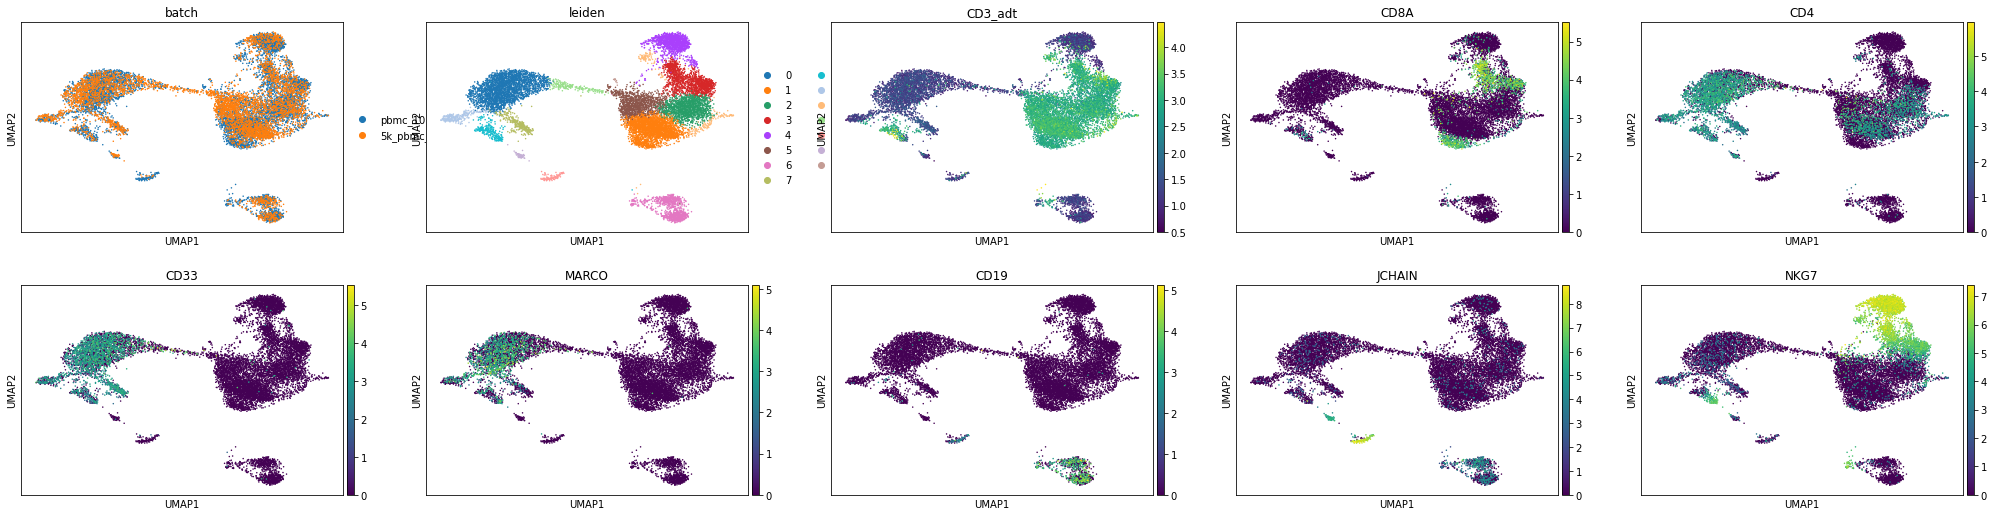

In [17]:
adata.obs[['CD3_adt','CD4_adt','CD8_adt','CD14_adt']] = adata.obsm['ADTnorm'][['CD3','CD4','CD8a','CD14']]
sc.pl.umap(adata,color=['batch','leiden','CD3_adt','CD8A','CD4','CD33','MARCO','CD19','JCHAIN','NKG7'],ncols=5)

#### How consistent is the classifier at predicting the ground truth data?
Confusion matricies score the training on held_out data! This is a very useful internal control (assuming your ground truth populations are pure) to tell you how well the random forests are performing! Cells on the diagonal are correctly called, and others are miscalled.

<i>Note that there're currently issues with batch spike-ins of rare classes, in that there is not a consistent 20% hold out maintained. Thus, exercise caution when interpreting these plots when large populations are used for spike ins. Also, if any column or row sums to 0, F1, Precision, and Recall values are invalid.</i>

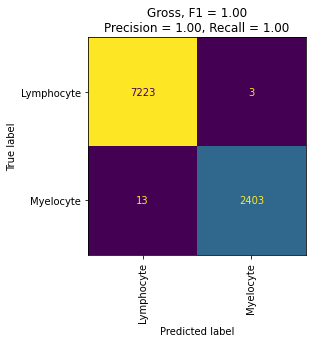

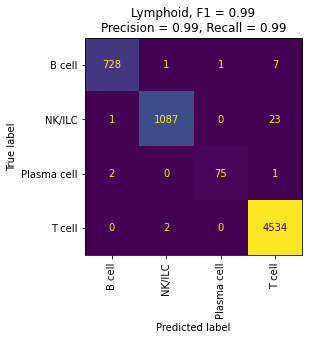

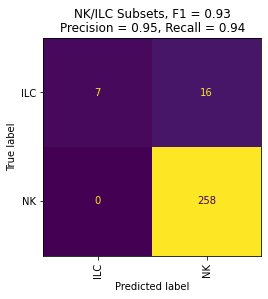

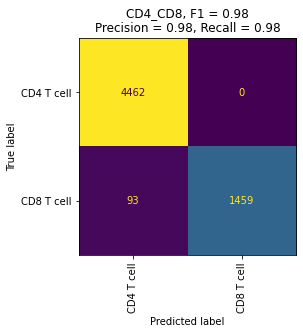

In [18]:
mmc.plot_confusion(adata,'All',hierarchy,show=True,hold_out_only=False)#, save='Confusion_plots.pdf')

#### How confident is classifier in the calls at each level? 

One metric for this might be the percent of trees in the forest that agree on the call. To test whether this is a good metric, we can use the held out data to plot calls by the binned percent of trees in agreement for each call against the percent accurate the call.

<i>Usually, this does not fit a 45 degree line, but these accuracies can be calibrated to get a more "true" confidence level.</i>

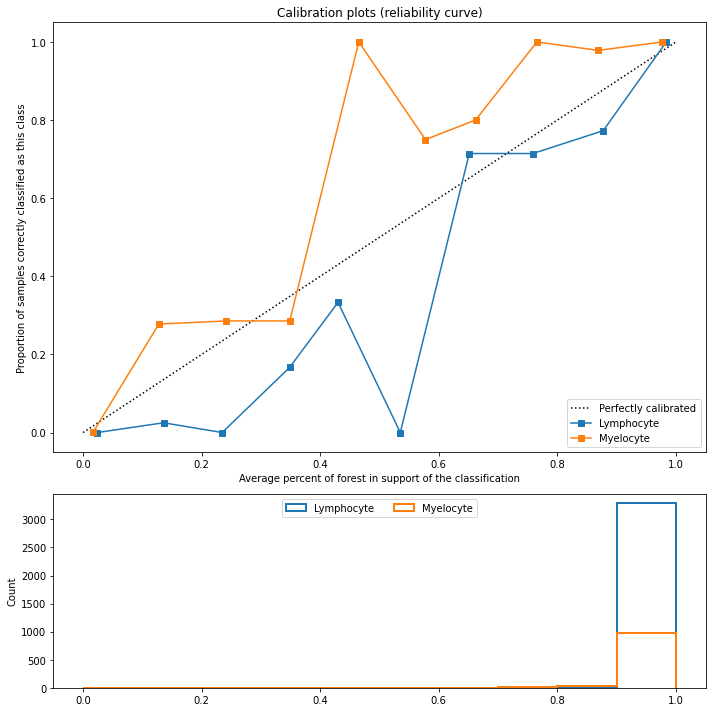

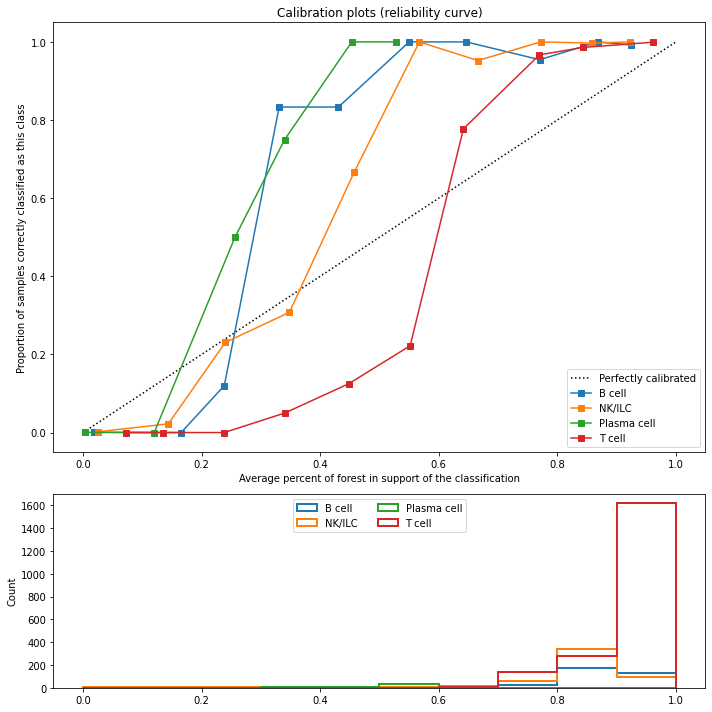

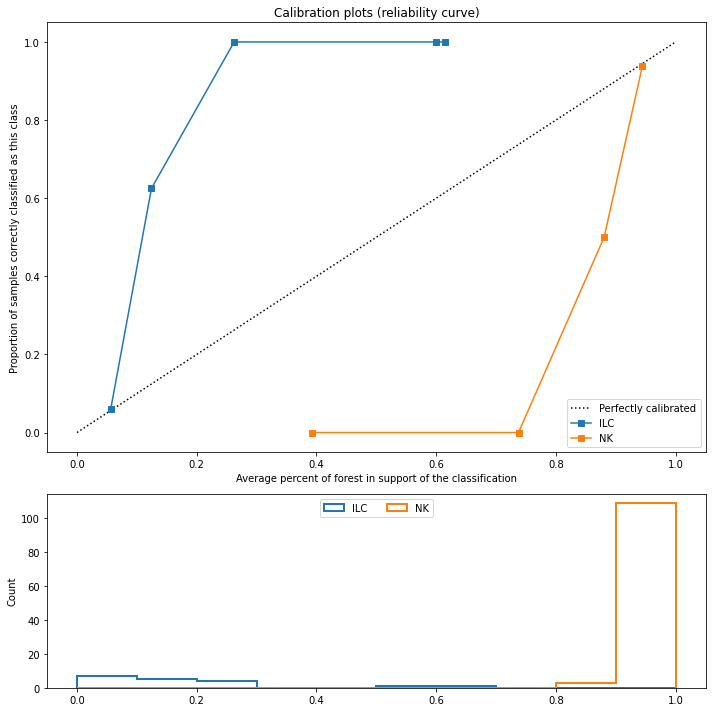

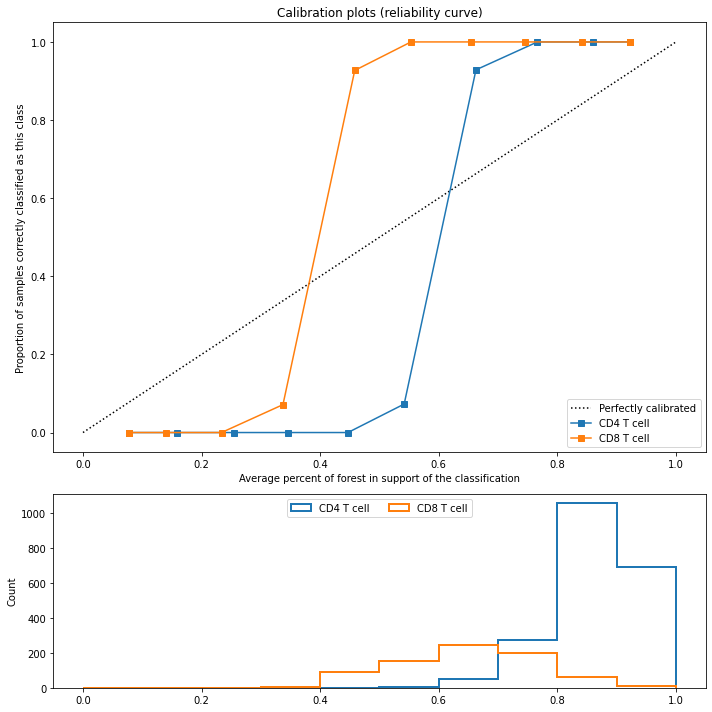

In [19]:
mmc.plot_confidence(adata,'All',hierarchy,show=True) #, save='Calibration_plots.pdf')

## <b style='color:orange'> Save and load your model!

The hierachy object can be saved for future classification as a .hierarchy file!

In [20]:
hierarchy.save('IntegratedClassifier')

To load the hierarchy, just specify the name in the object creation

In [21]:
hierarchy = mmc.Hierarchy(load='IntegratedClassifier')

Loading classifier from IntegratedClassifier...


Loaded IntegratedClassifier.hierarchy


## <b style='color:orange'> Run the classifier on another donor
Running the classifier on another donor requires the features line up exactly. Ideally, this means the feature matricies using the same or very similar alignment conditions, and both training and predicted datasets are subjected to similar preprocessing. This is all true for our held out dataset!
First, for ADTnorm, we must set a sample and batch column, and then use the ADTnorm function with the same settings as performed on our training dataset.

In [22]:
held_out_batch.obs[['sample','batch']] = 1

 /tmp/ipykernel_1855/785365858.py:1: ImplicitModificationWarning:Trying to modify attribute `.obs` of view, initializing view as actual.


In [23]:
held_out_batch = adtnormpy.adt_norm(held_out_batch,sample_column='batch',batch_column='batch',ADT_location='protein_counts',
                                    save_outpath=None,save_intermediate=False,input_raw_counts=True,exclude_zeroes=True,target_landmark=(1,3))

[1] "Will align negative peak to 1 and right-most positive peak to 3"
[1] "ADTnorm will process all the ADT markers from the ADT matrix:CD8a, CD15, IgG2b_control, CD16, CD56, CD4, CD25, CD14, PD-1, CD127, IgG2a_control, CD3, TIGIT, CD19, IgG1_control, CD45RO, CD45RA"
[1] "CD8a"
[1] "Zeroes excluded..."
      [,1]     [,2]
1 2.052661 6.676576
      [,1]     [,2]     [,3]
1 2.052661 4.550873 6.676576
[1] "CD15"
[1] "Zeroes excluded..."
      [,1]
1 2.104628
      [,1]     [,2]
1 2.104628 3.050213
[1] "IgG2b_control"
[1] "Zeroes excluded..."
       [,1]
1 0.8870197
       [,1]     [,2]
1 0.8870197 1.860675
[1] "CD16"
[1] "Zeroes excluded..."
      [,1]
1 1.872404
      [,1]     [,2]
1 1.872404 2.727297
[1] "CD56"
[1] "Zeroes excluded..."
      [,1]
1 1.936728
      [,1]     [,2]
1 1.936728 2.815669
[1] "CD4"
[1] "Zeroes excluded..."
      [,1]     [,2]     [,3]
1 1.840793 5.068106 7.219649
      [,1]     [,2]     [,3]
1 1.840793 3.454449 7.219649
[1] "CD25"
[1] "Zeroes excluded..."
      

Then, predicting on the data is as simple as running the classify function, and collecting the terminal names in the `.obs`. Note that this function runs much quicker than training a large dataset.

In [24]:
held_out_batch,_ = mmc.classify(held_out_batch,hierarchy,'lin',data_key='ADTnorm',reduce_features_min_cells=0)
held_out_batch = mmc.terminal_names(held_out_batch)

Setting up...
Using .X and ADTnorm
Reducing features...
No min_cells feature reduction...
Set up complete.
Using 33555 features
Data subsetted on All in All
Predicting for Gross...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


Merging data into adata.obsm['lin']
Predicted:
Lymphocyte    456
Myelocyte     257
Name: Gross_class, dtype: int64
Data subsetted on Lymphocyte in Gross
Predicting for Lymphoid...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


Merging data into adata.obsm['lin']
Predicted:
T cell         344
B cell          77
NK/ILC          30
Plasma cell      5
Name: Lymphoid_class, dtype: int64
Data subsetted on NK/ILC in Lymphoid
Predicting for NK/ILC Subsets...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


Merging data into adata.obsm['lin']
Predicted:
NK    30
Name: NK/ILC Subsets_class, dtype: int64
Data subsetted on T cell in Lymphoid
Predicting for CD4_CD8...
Merging data into adata.obsm['lin']
Predicted:
CD4 T cell    241
CD8 T cell    103
Name: CD4_CD8_class, dtype: int64


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


Lastly, to verify the classifier performed well, we can check whether the classifications align to known marker genes and proteins for these populations.

In [25]:
sc.pp.highly_variable_genes(held_out_batch)
sc.pp.pca(held_out_batch)
sc.pp.neighbors(held_out_batch)
sc.tl.umap(held_out_batch)
sc.tl.leiden(held_out_batch)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


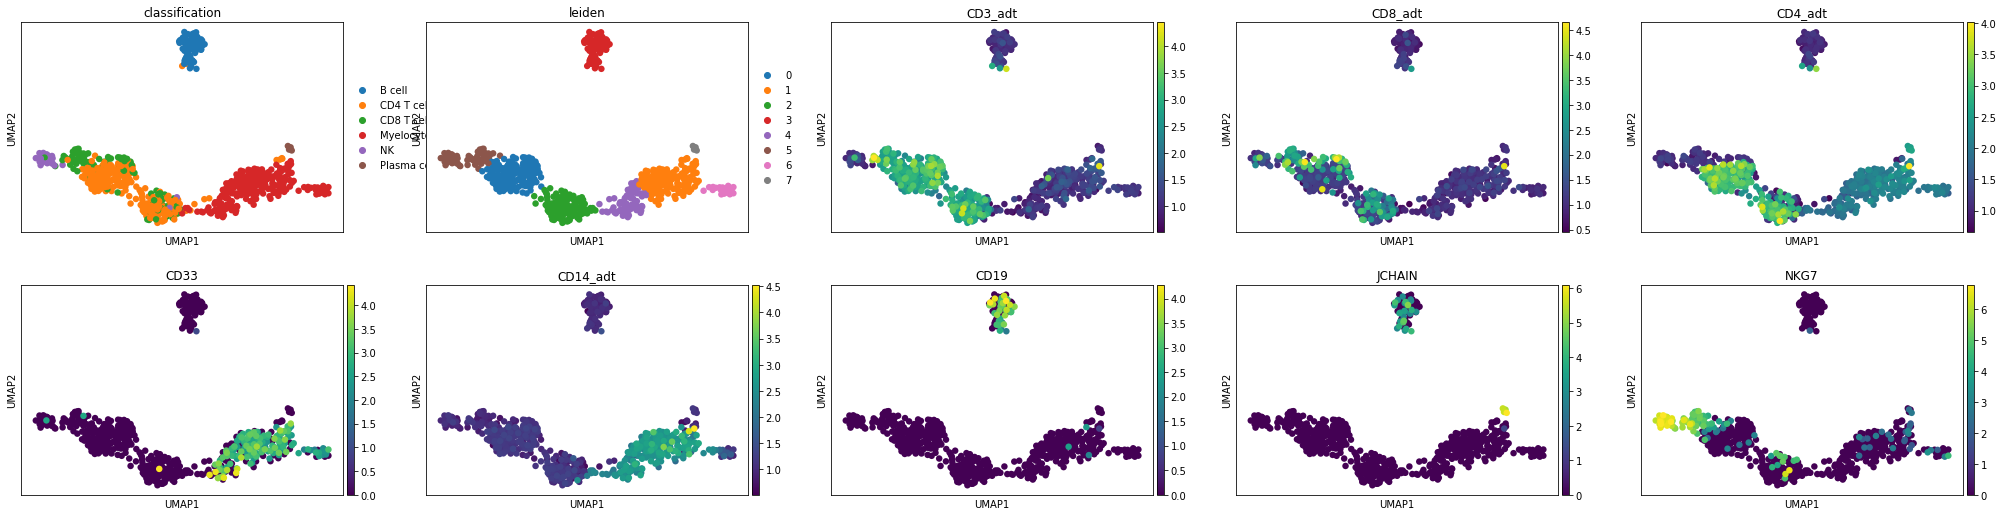

In [26]:
held_out_batch.obs[['CD3_adt','CD4_adt','CD8_adt','CD14_adt']] = held_out_batch.obsm['ADTnorm'][['CD3','CD4','CD8a','CD14']]
sc.pl.umap(held_out_batch,color=['classification','leiden','CD3_adt','CD8_adt','CD4_adt','CD33','CD14_adt','CD19','JCHAIN','NKG7'],ncols=5)

<div class="alert alert-block alert-success">
<b>Congratulations!</b> You've completed your first tutorial with MMoCHi!<br>
    Sit back and have a snack (some mochi maybe?) as we work on putting together more tutorials!
</div>